In [51]:
import time
import os
import math
import numpy as np
import cv2
import pandas as pd
import pyautogui as pa
from scipy.stats import binom_test
from matplotlib.markers import TICKDOWN
from matplotlib import rcParams
import datetime
from scipy.stats import norm, kstest, sem, ttest_ind
from numpy.polynomial import polynomial

from lib.auto_GUI.auto_GUI_base import AutoGUIBase
from lib.auto_GUI.auto_PhotoZ import AutoPhotoZ
from lib.analysis.laminar_dist import *
from lib.file.ROI_reader import ROIFileReader
from lib.analysis.cell_roi import OverlapCounterROI
from lib.analysis.baseline_correction import BaselineCorrection

In [52]:
data_dir = "C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/controlled_baseline/"
master_csv = data_dir + 'scnn1a-ppr.csv'
###################################
# SUMATION DECOMPOSITION
# UPDATE: Every other trace is a single-pulse control, for baseline subtraction and summation decomposition
# UPDATE: Data is right-aligned in the trace, the second pulse is always at point ~360
# Process paired-pulse ratio data
#    - IPIs are shuffled, open <slice>_<loc>shuffle.txt for IPI order
#    - extract Amplitude, half_width, latency for pulse 1 and pulse 2 for each ROI
#    - ROIs are in order (in file "<slice>_barrel_rois.dat" for each date subdir):
#          -  medial -> lateral if available
#          - otherwise, in some order that preserves neighbors (1,2 are neighbors and 2,3 are neighbors)
#    - which barrel is home barrel (stimulated) is recorded in master csv scnn1a-ppr.csv for each loc
###################################
enable_photoZ_interact = False
initialize_photoZ = False

# Amp cutoff is slice/loc specific, see scnn1a-ppr.csv

In [53]:
# set up PhotoZ (open it manually)
aPhz = AutoPhotoZ(data_dir=data_dir)
if initialize_photoZ and enable_photoZ_interact:
    aPhz.prepare_photoZ()
    # normalization needs to be off since we are saving arrays
    aPhz.click_normalize_2_array_max()

In [54]:
# load master csv file for metadata
master_df = pd.read_csv(master_csv)
master_df = pd.DataFrame(master_df)
master_df

,Date,Slice_Loc,Medial Dir,Stim Layer,Caudal/Rostral,Home Barrel,AmpCutoff
0,5/6/2024,1_1,NaN,L4,Rostral,1,1.1
1,5/6/2024,2_1,NaN,L4,Rostral,2,1.1
2,5/9/2024,2_1,NaN,L4,Rostral,2,0.9
3,5/9/2024,2_2,NaN,L4,Rostral,1,0.6
4,5/9/2024,3_1,NaN,L4,Caudal,1,1.1


In [55]:
def get_shuffle_filename(slic, loc):
    return str(slic) + "_" + str(loc) + "shuffle.txt"

def get_barrel_roi_filename(slic):
    return str(slic) + "_barrel_rois.dat"

# locate all files
data_map = {}
for subdir, dirs, files in os.walk(data_dir):
    if 'hidden' in subdir:
        continue
    if not ('dic' in dirs and 'selected_zda' in dirs):
        continue
    print("\n", subdir)
    dic_dir = subdir + "/dic/"
    selected_zda_dir = subdir + "/selected_zda/"
    data_map[subdir] = {}
    for zda_file in os.listdir(selected_zda_dir):
        if zda_file.endswith('.zda'):
            slr_id = zda_file.split('.')[0]
            slic_id, loc_id, rec_id = [int(x) for x in slr_id.split("_")]
            print(slic_id, loc_id, rec_id)
            if slic_id not in data_map[subdir]:
                # find ROI file and index it
                data_map[subdir][slic_id] = {'roi_file': selected_zda_dir + "/" + get_barrel_roi_filename(slic_id)}
            if loc_id not in data_map[subdir][slic_id]:
                # find shuffle file and index it
                data_map[subdir][slic_id][loc_id] = {'zda_files': [],
                                                     'shuffle_file': subdir + "/" +  get_shuffle_filename(slic_id, loc_id)}
            data_map[subdir][slic_id][loc_id]['zda_files'].append(selected_zda_dir + "/" + zda_file)  # appends in ascending order


 C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/controlled_baseline/05-06-24
1 1 2
1 1 3
1 1 4
1 1 5
1 1 6
1 1 7
1 1 8
1 1 9
1 1 10
1 1 11
1 1 12
1 1 13
1 1 14
1 1 15
2 1 2
2 1 3
2 1 4
2 1 5
2 1 6
2 1 7
2 1 8
2 1 9
2 1 10
2 1 11
2 1 12
2 1 13
2 1 14
2 1 15
2 1 16
2 1 17
2 1 18
2 1 19
2 1 20
2 1 21
2 1 22
2 1 23
2 1 24
2 1 25
2 1 26
2 1 27

 C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/controlled_baseline/05-09-24
2 1 2
2 1 3
2 1 4
2 1 5
2 1 6
2 1 7
2 1 8
2 1 9
2 1 10
2 1 11
2 1 12
2 1 13
2 1 14
2 1 15
2 1 16
2 1 17
2 1 18
2 1 19
2 1 20
2 1 21
2 1 22
2 1 23
2 1 24
2 1 25
2 1 26
2 1 27
2 2 2
2 2 3
2 2 4
2 2 5
2 2 6
2 2 7
2 2 8
2 2 9
2 2 10
2 2 11
2 2 12
2 2 13
2 2 14
2 2 15
2 2 16
2 2 17
2 2 18
2 2 19
2 2 20
2 2 21
2 2 22
2 2 23
2 2 24
2 2 25
3 1 2
3 1 3
3 1 4
3 1 5
3 1 6
3 1 7
3 1 8
3 1 9
3 1 10
3 1 11
3 1 12
3 1 13
3 1 14
3 1 15
3 1 16
3 1 17
3 1 18
3 1 19
3 1 20
3 1 21
3 1 22
3 1 23
3 1 24
3 1 25
3 1 26
3 1 27


In [56]:
# go through the IPIs in their shuffled order (ascending recordings) 
# and extract the entire trace for each ROI
# Every second recording is a single-pulse control
if enable_photoZ_interact:
    pa.alert("Starting trace extraction, leave Polynomial off and set trace window in Save/Load tab!")
for subdir in data_map:
    aPhz = AutoPhotoZ(data_dir=subdir)
    print(subdir)
    for slic_id in data_map[subdir]:

        # open roi_file for whole slice
        if enable_photoZ_interact:
            roi_file = data_map[subdir][slic_id]['roi_file']
            aPhz.select_roi_tab()
            aPhz.open_roi_file(roi_file)

        for loc_id in data_map[subdir][slic_id]:
            if type(loc_id) == str:
                continue
            slic_loc_id = str(slic_id) + "_" + str(loc_id)

            ipi_file = data_map[subdir][slic_id][loc_id]['shuffle_file']
            with open(ipi_file, 'r') as f:
                lines = f.readlines() 
            ipi_order = [x for x in lines]
            for k in range(len(ipi_order)):
                ipi = ipi_order[k].split("\t")
                ipi = int(ipi[1]) - int(ipi[0])
                ipi_order[k] = ipi

            if len(data_map[subdir][slic_id][loc_id]['zda_files']) % 2 != 0:
                raise Exception("Odd number of recordings for", subdir, slic_id, loc_id, "may be missing " +
                                "a single-pulse control!")
            # open zda files in order
            i_ipi = -1
            for i_zda_file in range(0, len(data_map[subdir][slic_id][loc_id]['zda_files']), 2):
                zda_file = data_map[subdir][slic_id][loc_id]['zda_files'][i_zda_file]
                i_ipi += 1
                try:
                    ipi = ipi_order[i_ipi]
                except Exception as e:
                    print(e)
                    print("Not enough IPIs for how many recordings we have! Last IPI:", ipi, "Check", subdir)
                print(slic_id, loc_id, "IPI:", ipi, "ms for recording", zda_file.split("/")[-1])
                
                # no need for baseline subtraction in PhotoZ, we do that after
                '''# set polynomial skip window to eclipse BOTH pulses
                if enable_photoZ_interact:
                    end_skip = 550
                    first_pulse_start = 356 - (ipi * 2)
                    skip_width = end_skip - first_pulse_start
                    aPhz.set_polynomial_skip_window(first_pulse_start,
                                                    skip_width=skip_width)'''

                # save entire traces
                trace_filename = subdir + "/" + "traces_" + slic_loc_id + "_ipi" + str(ipi) + ".dat"
                if os.path.exists(trace_filename):
                    print("\tAlready saved trace", trace_filename)
                elif enable_photoZ_interact:
                    aPhz.open_zda_file(zda_file)
                    time.sleep(13)
                    print("\tSaving traces...")
                    aPhz.save_current_traces(trace_filename, go_to_tab=True)
                    print("\tSaved trace", trace_filename)

                # go to next trace and save control trace
                next_zda_file = data_map[subdir][slic_id][loc_id]['zda_files'][i_zda_file + 1]
                next_trace_filename = subdir + "/" + "traces_" + slic_loc_id + "_ipi" + str(ipi) + "_control.dat"
                if os.path.exists(next_trace_filename):
                    print("\tAlready saved trace", next_trace_filename)
                elif enable_photoZ_interact:
                    aPhz.open_zda_file(next_zda_file)
                    time.sleep(13)
                    print("\tSaving traces...")
                    aPhz.save_current_traces(next_trace_filename, go_to_tab=True)
                    print("\tSaved trace", next_trace_filename)
                

                '''# save half-width values from PhotoZ
                hw_filename = subdir + "/" + "hw_" + slic_loc_id + "_ipi" + str(ipi) + "_p" + str(i_pulse) + ".dat" 
                if enable_photoZ_interact:
                    aPhz.select_half_width_trace_value()
                    aPhz.save_trace_values(hw_filename)

                # save amp values from PhotoZ
                amp_filename = subdir + "/" + "amp_" + slic_loc_id + "_ipi" + str(ipi) + "_p" + str(i_pulse) + ".dat"
                if enable_photoZ_interact:
                    aPhz.select_maxamp_trace_value()
                    aPhz.save_trace_values(amp_filename)
                    
                # save latency values from PhotoZ
                lat_filename = subdir + "/" + "lat_" + slic_loc_id + "_ipi" + str(ipi) + "_p" + str(i_pulse) + ".dat"
                if enable_photoZ_interact:
                    aPhz.select_latency_trace_value()
                    aPhz.save_trace_values(lat_filename)'''

                data_map[subdir][slic_id][loc_id][ipi] = {'trace': trace_filename,
                                                          'control_trace': next_trace_filename}
            if i_ipi < len(ipi_order) - 1:
                print("Not enough recordings for how many IPIs we have! Last IPI:", ipi, "Check", subdir)


C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/controlled_baseline/05-06-24
1 1 IPI: 80 ms for recording 01_01_02.zda
	Already saved trace C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/controlled_baseline/05-06-24/traces_1_1_ipi80.dat
	Already saved trace C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/controlled_baseline/05-06-24/traces_1_1_ipi80_control.dat
1 1 IPI: 10 ms for recording 01_01_04.zda
	Already saved trace C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/controlled_baseline/05-06-24/traces_1_1_ipi10.dat
	Already saved trace C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/controlled_baseline/05-06-24/traces_1_1_ipi10_control.dat
1 1 IPI: 30 ms for recording 01_01_06.zda
	Already saved trace C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/controlled_baseline/05-06-24/traces_1_1_ipi30.dat
	Already saved trace C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/controlled_baseline/05-06-24/traces_1_1_ipi30_control.dat
1 1 IPI: 9

5/6/2024 1_1
	IPI: 80


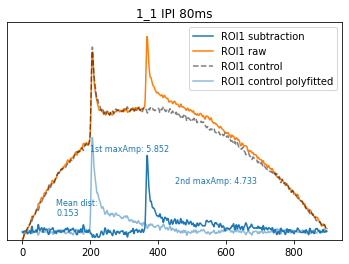

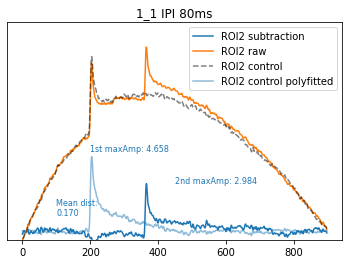

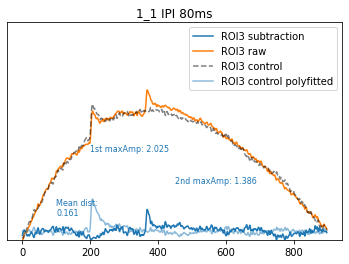

	IPI: 10
	IPI: 30


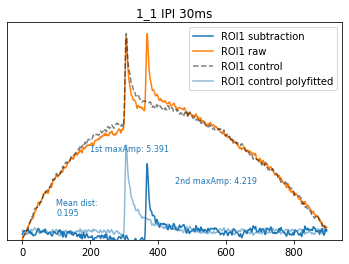

	IPI: 90


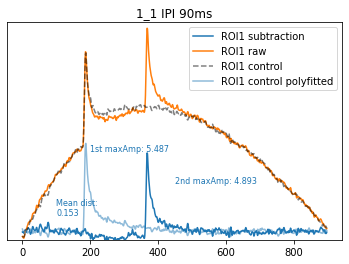

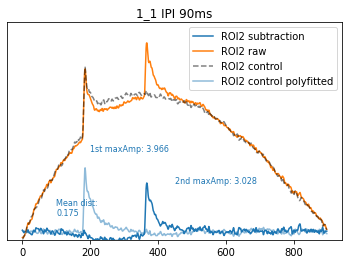

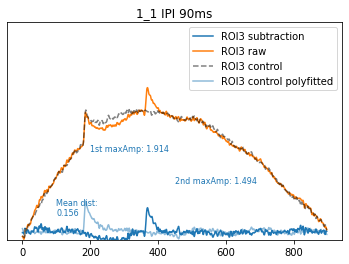

	IPI: 120
	IPI: 100
	IPI: 70
5/6/2024 2_1
	IPI: 10


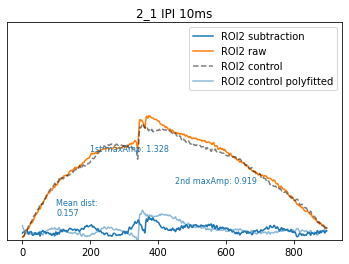

	IPI: 80
	IPI: 40
	IPI: 110


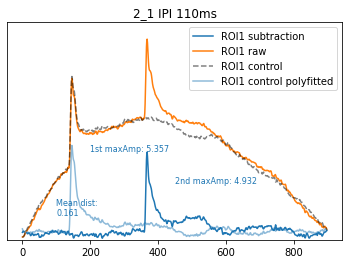

	IPI: 100


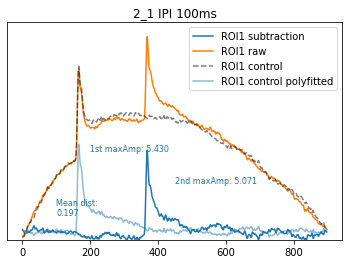

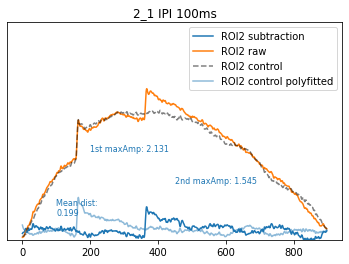

	IPI: 120


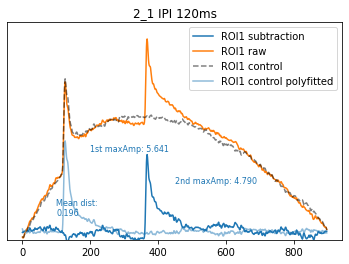

	IPI: 70


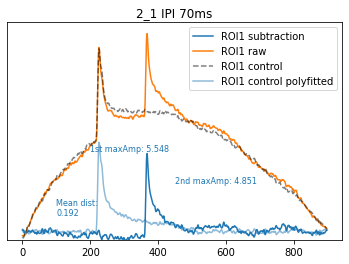

	IPI: 60


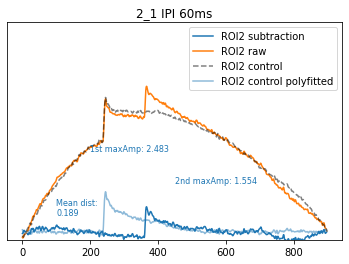

	IPI: 130
	IPI: 20


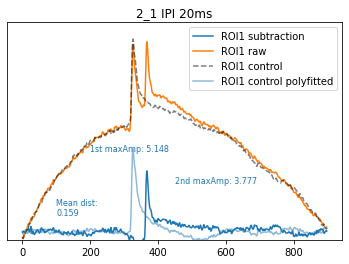

	IPI: 90
	IPI: 30


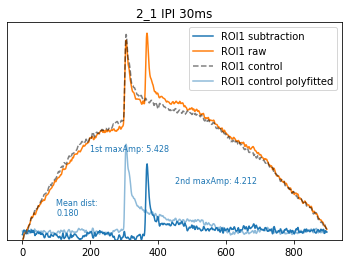

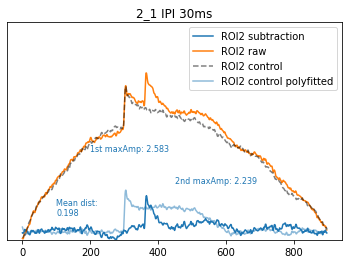

	IPI: 50


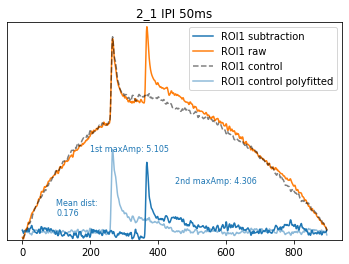

5/9/2024 2_1
	IPI: 40


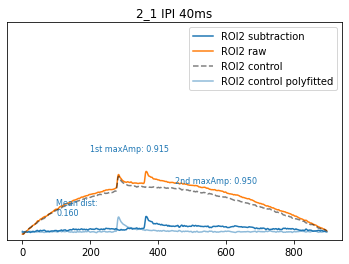

	IPI: 90


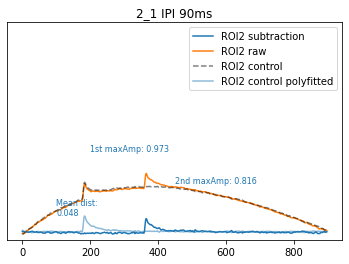

	IPI: 10


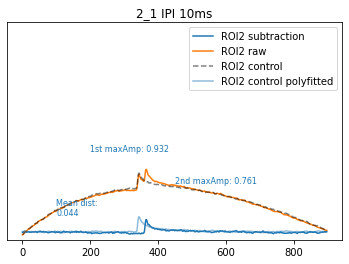

	IPI: 110


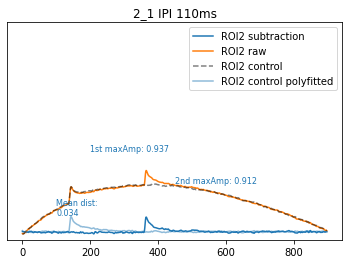

	IPI: 50


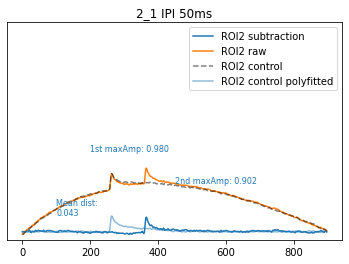

	IPI: 80


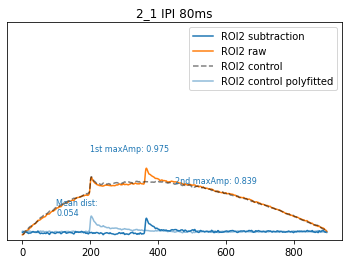

	IPI: 100


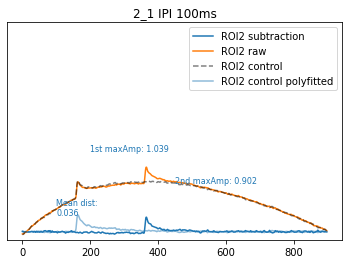

	IPI: 120


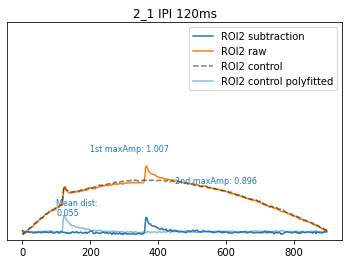

	IPI: 20


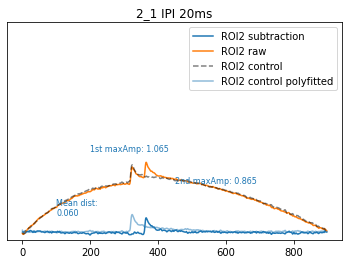

	IPI: 130


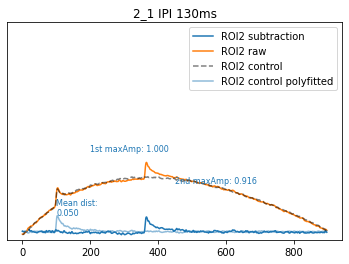

	IPI: 70


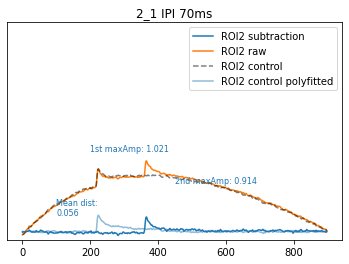

	IPI: 60


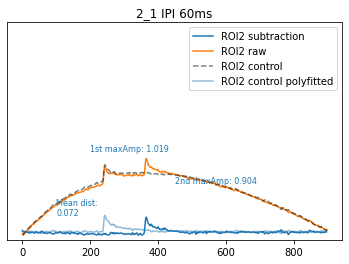

	IPI: 30


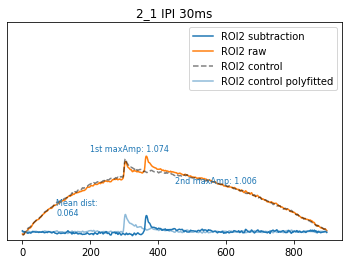

5/9/2024 2_2
	IPI: 10


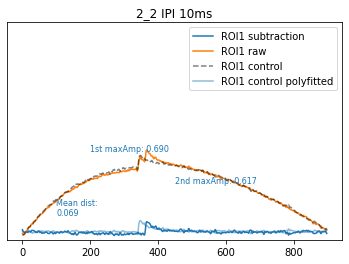

	IPI: 120


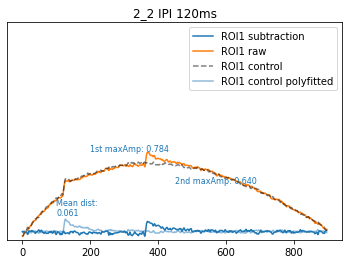

	IPI: 20


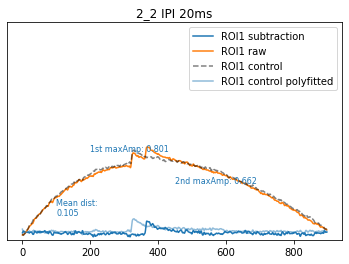

	IPI: 60


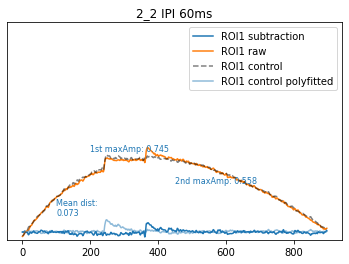

	IPI: 50


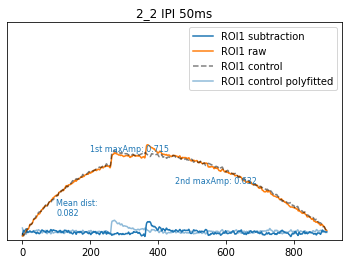

	IPI: 90


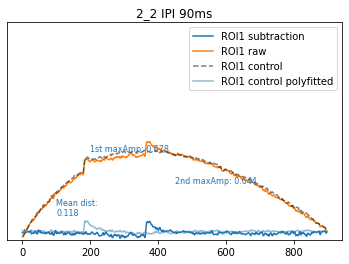

	IPI: 30


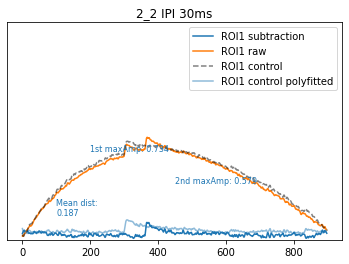

	IPI: 130


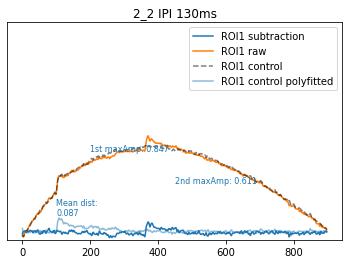

	IPI: 100


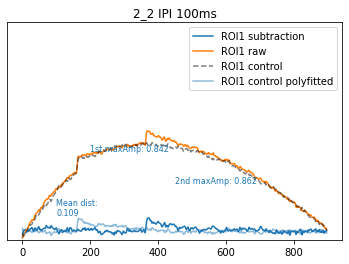

	IPI: 40


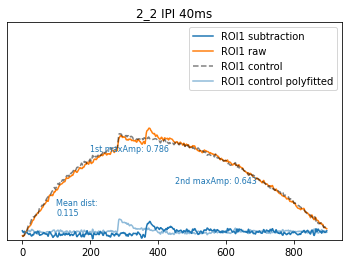

	IPI: 70


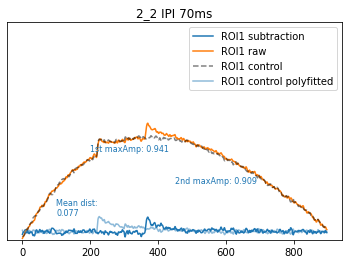

	IPI: 80


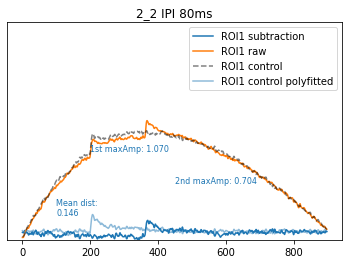

5/9/2024 3_1
	IPI: 130
	IPI: 70


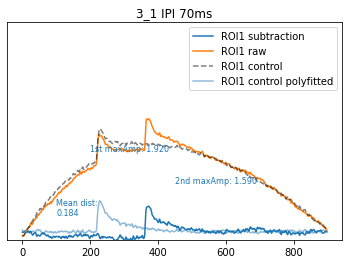

	IPI: 80


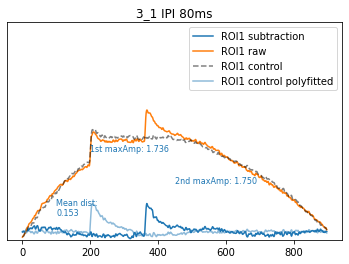

	IPI: 90


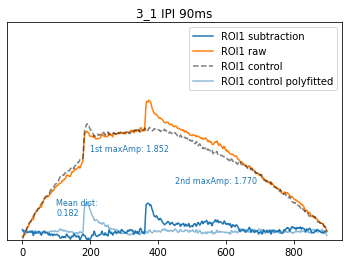

	IPI: 110
	IPI: 20


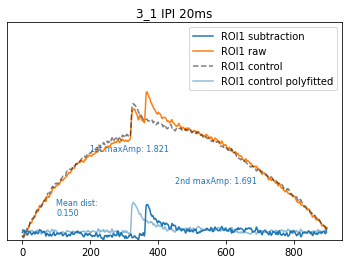

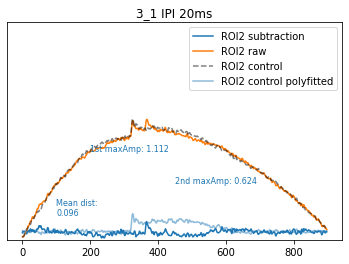

	IPI: 40


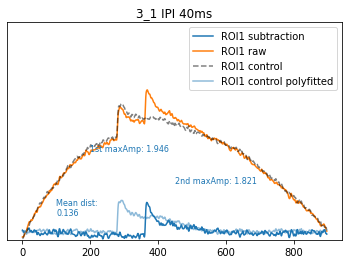

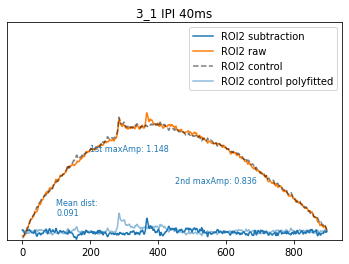

	IPI: 120


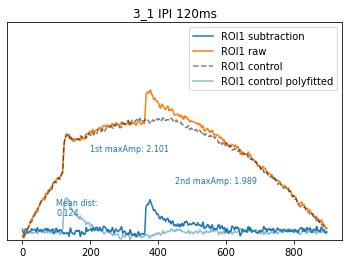

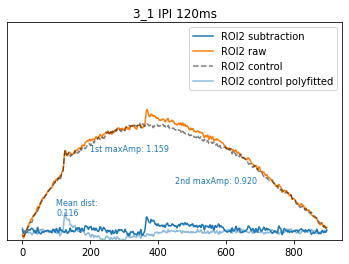

	IPI: 60
	IPI: 10
	IPI: 100


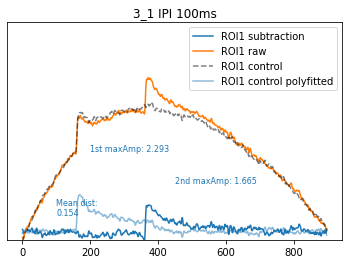

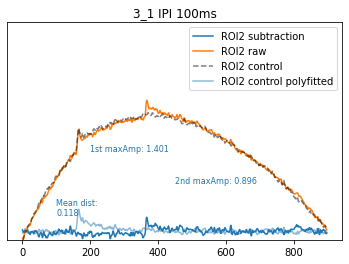

	IPI: 30
	IPI: 50


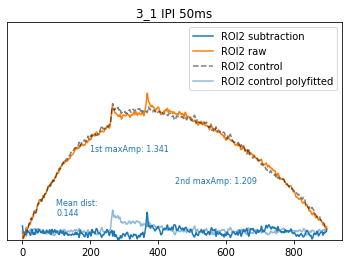

In [57]:
control_match_dist_cutoff = 0.2  # if STDEV of subtraction is greater than this, skip
view_all = False 

'''Now load traces and perform summation decomposition by 
subtracting the control trace from the paired-pulse trace. '''
def read_dat_trace_file(filename):
    data_arr = pd.read_csv(filename,
                                 sep='\t',
                                 header=0)  # change me to traces?
    data_arr = data_arr.apply(pd.to_numeric, errors='coerce')
    return data_arr


snr_dfs = []
for subdir in data_map:
    
    # extract date from subdir so we can look up metadata from master_df
    date = subdir.split("/")[-1].split('-')
    date = [int(x) for x in date]
    date[-1] += 2000
    date = "/".join([str(x) for x in date])
    metadata_date = master_df[master_df['Date'] == date]
    
    for slic_id in data_map[subdir]:
        for loc_id in data_map[subdir][slic_id]:
            if type(loc_id) == str:
                continue
            slic_loc_id = str(slic_id) + "_" + str(loc_id)
            amp_cutoff = float(master_df[(master_df['Date'] == date) & (master_df['Slice_Loc'] == slic_loc_id)]['AmpCutoff'].item())
            print(date, slic_loc_id)
            metadata = metadata_date[metadata_date['Slice_Loc'] == slic_loc_id]
            medial_dir = metadata['Medial Dir'].item()
            stim_layer = metadata['Stim Layer'].item()
            caudal_rostral = metadata['Caudal/Rostral'].item()
            home_barrel = int(metadata['Home Barrel'].item())

            for ipi in data_map[subdir][slic_id][loc_id]:
                if type(ipi) == str:
                    continue
                print("\tIPI:", ipi)

                # load traces and control traces for this ipi
                trace_filename = data_map[subdir][slic_id][loc_id][ipi]['trace']
                control_trace_filename = data_map[subdir][slic_id][loc_id][ipi]['control_trace']
                trace = read_dat_trace_file(trace_filename)
                control_trace = read_dat_trace_file(control_trace_filename)

                # show both traces and their subtraction
                trace_sub = trace - control_trace
                trace_sub = trace_sub.drop(columns=['Pt'])
                trace_sub = trace_sub.dropna()

                # calculate dist from zero of subtracted trace before second stim
                trace_sub_dist = trace_sub[(trace_sub.index < 356) | (trace_sub.index > 550)].abs().mean()

                # calculate maxAmp of subtracted trace in measure window (356 - 370)
                trace_sub_max = trace_sub[(trace_sub.index > 356) & (trace_sub.index < 450)].max()

                # perform baseline subtraction on control trace
                first_stim_start = 356 - (ipi * 2)
                exclusion_window = (first_stim_start, first_stim_start + 290)
                bc = BaselineCorrection(control_trace, exclusion_windows=[exclusion_window])
                control_trace_max = {}
                control_trace_corrected = {}
                for roi in control_trace.columns:
                    if roi == 'Pt':
                        continue
                    control_trace_corrected[roi] = bc.fit_baseline(roi, date+ " " + slic_loc_id + " IPI " + str(ipi) + "ms")
                    # measure MaxAmp of control trace in first stim site measure window

                    control_trace_max[roi] = control_trace[(control_trace.index > first_stim_start) 
                                                        & (control_trace.index < first_stim_start + 104)]['Corrected_'+roi].max()
                
                for roi in control_trace.columns:
                    if not ('ROI' in roi and len(roi) == 4):
                        continue

                    # filters
                    if not view_all:
                        if trace_sub_dist[roi] > control_match_dist_cutoff:  # skip if magnitude of subtraction is too high
                            continue
                        if trace_sub_max[roi] < amp_cutoff and control_trace_max[roi] < amp_cutoff:  # skip if maxAmp of subtraction is too low
                            continue
                    plt.plot(trace_sub[roi], c='tab:blue', label= roi + ' subtraction')
                    plt.plot(trace[roi], c='tab:orange', label= roi + ' raw')
                    plt.plot(control_trace[roi], 'k--', label= roi + ' control', alpha=0.5)
                    plt.plot(control_trace_corrected[roi], c='tab:blue', label= roi + ' control polyfitted', alpha=0.5)
                    plt.annotate("Mean dist:\n" + str(trace_sub_dist[roi])[:5], 
                                 xy=(100, 1), fontsize=8, color='tab:blue')
                    # annotate maxAmp of subtracted trace
                    plt.annotate("2nd maxAmp: " + str(trace_sub_max[roi])[:5], xy=(450, 3), fontsize=8, color='tab:blue')
                    # annotate maxAmp of control trace
                    plt.annotate("1st maxAmp: " + str(control_trace_max[roi])[:5], xy=(200, 5), fontsize=8, color='tab:blue')
                    plt.legend()
                    plt.yticks([])
                    plt.title(slic_loc_id + " IPI " + str(ipi) + "ms")
                    plt.ylim([-.5, 13])
                    plt.show()

                '''snr.insert(5, 'IPI', [ipi for _ in range(len(snr['ROI']))])
                snr.insert(6, 'Medial Dir', [medial_dir for _ in range(len(snr['ROI']))])
                snr.insert(7, 'Stim Layer', [stim_layer for _ in range(len(snr['ROI']))])
                snr.insert(8, 'Caudal/Rostral', [caudal_rostral for _ in range(len(snr['ROI']))])
                snr.insert(9, 'Home Barrel', [home_barrel for _ in range(len(snr['ROI']))])
                snr.insert(10, 'Date', [date for _ in range(len(snr['ROI']))])
                snr.insert(11, 'Slice_Loc', [slic_loc_id for _ in range(len(snr['ROI']))])
                #snr.insert(12, "Actual Stim", [actual_stim for _ in range(len(snr['ROI']))])
                snr = snr[pd.to_numeric(snr.Value, errors='coerce').notnull()]
                snr_dfs.append(snr)'''


In [58]:
        
pre_filter_snr = pd.concat(snr_dfs)
pre_filter_snr = pre_filter_snr[['Date', 'Slice_Loc', 'ROI', 'Value', 'Value_amp', 'Value_hw', 
                                 'Value_lat', 'Pulse', 'IPI',
                                 'Medial Dir', 'Stim Layer', 'Caudal/Rostral', 'Home Barrel']] #, 'Actual Stim']]

# correct Latency for actual stim time
#pre_filter_snr['Value_lat'] = pre_filter_snr['Value_lat'] - pre_filter_snr['Actual Stim']

pre_filter_snr = pre_filter_snr.rename(columns={'Value': "SNR",
                                                'Value_amp': "Amp", 
                                                'Value_hw' : "Halfwidth", 
                                                'Value_lat': "Latency"})
pre_filter_snr["Amp"] = pd.to_numeric(pre_filter_snr["Amp"])
pre_filter_snr['PPR'] = ''
pre_filter_snr

ValueError: No objects to concatenate

In [ ]:
for date in pre_filter_snr['Date'].unique():
    print(pre_filter_snr[pre_filter_snr['Date'] == date]['Slice_Loc'].unique())

['2_1' '3_1' '5_1']
['1_2' '1_3' '2_1' '2_2']
['1_1']


In [ ]:
amps1 = []
amps2 = []
ipis = []
# Now compute PPR = Amp(pulse 2) / Amp(pulse 1). 
for date in pre_filter_snr['Date'].unique():
    pfs_date = pre_filter_snr[pre_filter_snr["Date"] == date]
    for slic_loc in pfs_date['Slice_Loc'].unique():
        pfs_sl = pfs_date[pfs_date["Slice_Loc"] == slic_loc]
        for roi in pfs_sl['ROI'].unique():
            pfs_roi = pfs_sl[pfs_sl['ROI'] == roi]
            for ipi in pfs_roi['IPI'].unique():
                pfs_ipi = pfs_roi[pfs_roi['IPI'] == ipi]
                assert len(pfs_ipi) == 2  # should always be exactly 2 (otherwise can't compute PPR)

                amp1 = pfs_ipi[pfs_ipi['Pulse'] == 1]['Amp'].item()
                lat1 = pfs_ipi[pfs_ipi['Pulse'] == 1]['Latency'].item()
                hw1 = pfs_ipi[pfs_ipi['Pulse'] == 1]['Halfwidth'].item()

                # Compute PPR = Amp(pulse 2) / Amp(pulse 1)
                ppr = None
                if amp1 != 0:
                    amp2 = pfs_ipi[pfs_ipi['Pulse'] == 2]['Amp'].item()
                    ppr = amp2 / amp1
                if ppr is not None and 0 < ppr < 2:
                    pre_filter_snr.loc[(pre_filter_snr['Date'] == date) &
                                   (pre_filter_snr['Slice_Loc'] == slic_loc) &
                                   (pre_filter_snr['ROI'] == roi) & 
                                   (pre_filter_snr['IPI'] == ipi), 
                                       'PPR'] = ppr
                    amps1.append(amp1)
                    amps2.append(amp2)
                    ipis.append(ipi)
                
                # Compute PPL = Latency(pulse 2) / Latency(pulse 1)
                ppl = None
                if lat1 != 0:
                    lat2 = pfs_ipi[pfs_ipi['Pulse'] == 2]['Latency'].item()
                    ppl = lat2 / lat1
                if ppl is not None and 0 < ppl:
                    pre_filter_snr.loc[(pre_filter_snr['Date'] == date) &
                                   (pre_filter_snr['Slice_Loc'] == slic_loc) &
                                   (pre_filter_snr['ROI'] == roi) & 
                                   (pre_filter_snr['IPI'] == ipi), 
                                       'PPL'] = ppl
                    
                # Compute PPHW = Halfwidth(pulse 2) / Halfwidth(pulse 1)
                pphw = None
                if hw1 != 0:
                    hw2 = pfs_ipi[pfs_ipi['Pulse'] == 2]['Halfwidth'].item()
                    pphw = hw2 / hw1
                if pphw is not None and 0 < pphw:
                    pre_filter_snr.loc[(pre_filter_snr['Date'] == date) &
                                   (pre_filter_snr['Slice_Loc'] == slic_loc) &
                                   (pre_filter_snr['ROI'] == roi) & 
                                   (pre_filter_snr['IPI'] == ipi), 
                                       'PPHW'] = pphw

pre_filter_snr["PPR"] = pd.to_numeric(pre_filter_snr["PPR"])
pre_filter_snr["PPL"] = pd.to_numeric(pre_filter_snr["PPL"])
pre_filter_snr["PPHW"] = pd.to_numeric(pre_filter_snr["PPHW"])
# write to csv
csv_filename = 'scnn1a-ppr-output.csv'
pre_filter_snr.to_csv(data_dir + csv_filename, index=False)
pre_filter_snr


,Date,Slice_Loc,ROI,SNR,Amp,Halfwidth,Latency,Pulse,IPI,Medial Dir,Stim Layer,Caudal/Rostral,Home Barrel,PPR,PPL,PPHW
0,4/24/2024,2_1,1,7.722240,0.171305,-225.92900,112.6040,1,70,NaN,L4,Rostral,2,1.412627,1.614206,1.599494
1,4/24/2024,2_1,2,25.610100,0.808173,6.15237,109.6130,1,70,NaN,L4,Rostral,2,1.101799,1.647013,1.282455
2,4/24/2024,2_1,3,12.197600,0.331204,-224.01600,111.0890,1,70,NaN,L4,Rostral,2,1.074148,1.633276,1.610068
0,4/24/2024,2_1,1,10.908700,0.241990,-361.37200,181.7660,2,70,NaN,L4,Rostral,2,1.412627,1.614206,1.599494
1,4/24/2024,2_1,2,28.217200,0.890444,7.89014,180.5340,2,70,NaN,L4,Rostral,2,1.101799,1.647013,1.282455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,5/1/2024,1_1,2,28.768400,0.662690,7.97874,80.3312,1,100,NaN,L4,Rostral,2,0.956483,2.256521,1.139254
2,5/1/2024,1_1,3,0.640156,0.022483,2.06556,82.3683,1,100,NaN,L4,Rostral,2,1.555485,2.191438,2.829523
0,5/1/2024,1_1,1,1.498070,0.064114,4.92949,183.3690,2,100,NaN,L4,Rostral,2,1.076563,2.225698,1.764370
1,5/1/2024,1_1,2,27.516500,0.633852,9.08981,181.2690,2,100,NaN,L4,Rostral,2,0.956483,2.256521,1.139254


In [ ]:
# now some filtering
all_snr = pre_filter_snr[pre_filter_snr['SNR'] > snr_cutoff_signal]
#all_snr = all_snr[all_snr['Halfwidth'] > 0.5]
#all_snr = all_snr[all_snr['Halfwidth'] < 13]
#all_snr = all_snr[all_snr['Latency'] < 15]
#all_snr = all_snr[all_snr['Latency'] > 0]
all_snr = all_snr[all_snr['Amp'] > amp_cutoff]
all_snr = all_snr[all_snr['IPI'] < 140]  # 140 ms IPI cannot be measured properly with this setup
#all_snr = all_snr[all_snr['Date'] != '12/8/2023']  # exclude due to faulty baseline correction

all_snr

,Date,Slice_Loc,ROI,SNR,Amp,Halfwidth,Latency,Pulse,IPI,Medial Dir,Stim Layer,Caudal/Rostral,Home Barrel,PPR,PPL,PPHW
1,4/24/2024,2_1,2,25.6101,0.808173,6.15237,109.6130,1,70,NaN,L4,Rostral,2,1.101799,1.647013,1.282455
1,4/24/2024,2_1,2,28.2172,0.890444,7.89014,180.5340,2,70,NaN,L4,Rostral,2,1.101799,1.647013,1.282455
1,4/24/2024,2_1,2,18.9656,0.864373,6.63281,169.7500,1,10,NaN,L4,Rostral,2,1.221463,1.060713,1.225405
1,4/24/2024,2_1,2,23.1657,1.055800,8.12788,180.0560,2,10,NaN,L4,Rostral,2,1.221463,1.060713,1.225405
2,4/24/2024,2_1,3,10.5071,0.503630,8.41180,180.7560,2,10,NaN,L4,Rostral,2,1.371837,1.058315,0.993963
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,5/1/2024,1_1,2,30.2771,0.738880,-356.21600,181.0020,2,40,NaN,L4,Rostral,2,1.107632,1.289115,NaN
1,5/1/2024,1_1,2,38.9817,0.689745,7.67472,50.4441,1,130,NaN,L4,Rostral,2,0.828484,3.598022,0.821721
1,5/1/2024,1_1,2,32.2957,0.571443,6.30648,181.4990,2,130,NaN,L4,Rostral,2,0.828484,3.598022,0.821721
1,5/1/2024,1_1,2,28.7684,0.662690,7.97874,80.3312,1,100,NaN,L4,Rostral,2,0.956483,2.256521,1.139254


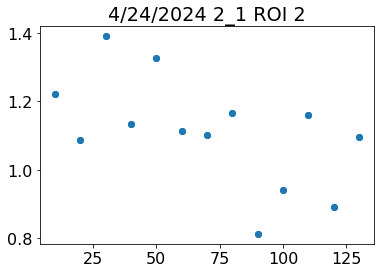

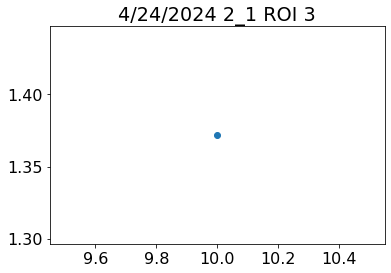

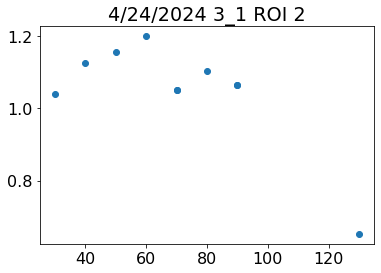

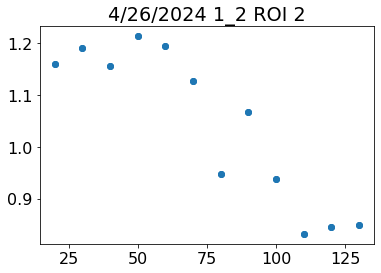

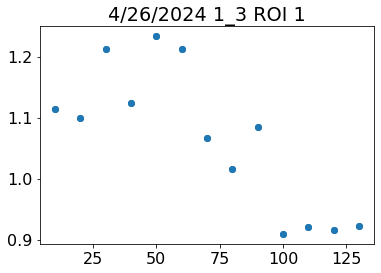

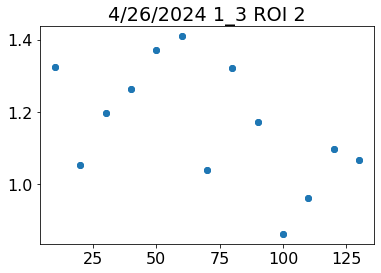

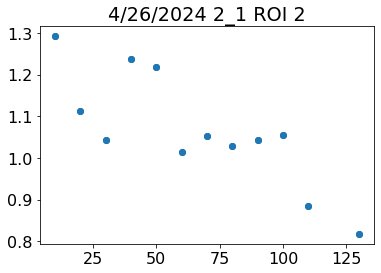

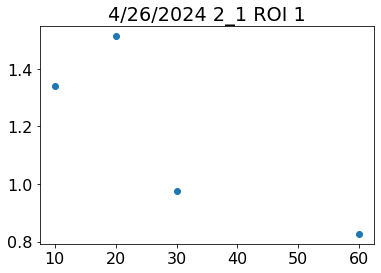

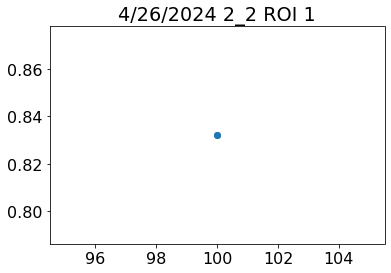

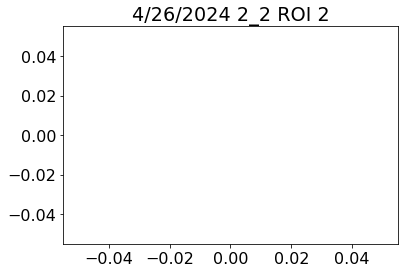

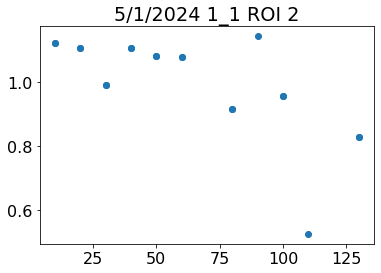

In [ ]:
# for each date, slice/loc, and ROI, plot PPR vs IPI
for date in all_snr['Date'].unique():
    pfs_date = all_snr[all_snr["Date"] == date]
    for slic_loc in pfs_date['Slice_Loc'].unique():
        pfs_sl = pfs_date[pfs_date["Slice_Loc"] == slic_loc]
        for roi in pfs_sl['ROI'].unique():
            pfs_roi = pfs_sl[pfs_sl['ROI'] == roi]
            plt.scatter(pfs_roi['IPI'], pfs_roi['PPR'])
            plt.title(date + " " + slic_loc + " ROI " + str(roi))
            plt.show()
            '''plt.scatter(pfs_roi['IPI'], pfs_roi['PPL'], c='r')
            plt.title(date + " " + slic_loc + " ROI " + str(roi))
            plt.show()
            plt.scatter(pfs_roi['IPI'], pfs_roi['PPHW'], c='g')
            plt.title(date + " " + slic_loc + " ROI " + str(roi))
            plt.show()'''

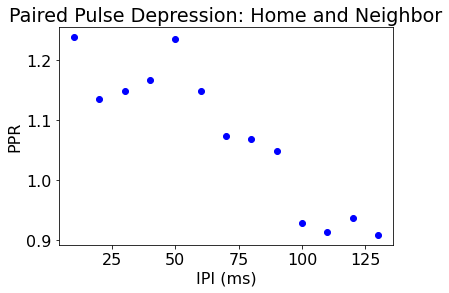

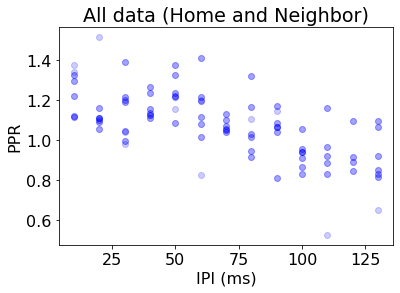

In [ ]:
# average grouping by IPI
for pp_type, color in [['PPR', 'b']]: #, ['PPL', 'r'], ['PPHW', 'g']]:
    group_by_ipi = all_snr[['IPI', pp_type]].groupby(by=['IPI']).mean()
    group_by_ipi_std = all_snr[['IPI', pp_type]].groupby(by=['IPI']).agg(np.std)
    group_by_ipi.reset_index(inplace=True)
    
    

    # plot average PPR vs IPI
    plt.scatter(group_by_ipi['IPI'], group_by_ipi[pp_type], c=color)
    plt.title("Paired Pulse Depression: Home and Neighbor")
    plt.xlabel("IPI (ms)")
    plt.ylabel(pp_type)
    plt.show()
    plt.scatter(all_snr['IPI'], all_snr[pp_type], alpha=0.2, c=color)
    plt.xlabel("IPI (ms)")
    plt.ylabel(pp_type)
    plt.title("All data (Home and Neighbor)")
    plt.show()

     PPR
IPI     
10     8
20    10
30    11
40    11
50    11
60    11
70    10
80    11
90    11
100   12
110    9
120    6
130   11
i= 0
10
p_val for IPI 20 : nan
p_val for IPI 30 : nan
p_val for IPI 40 : nan
p_val for IPI 50 : nan
p_val for IPI 60 : nan
p_val for IPI 70 : nan
p_val for IPI 80 : nan
p_val for IPI 90 : nan
p_val for IPI 100 : nan
p_val for IPI 110 : nan
p_val for IPI 120 : nan
p_val for IPI 130 : nan
[None, None, None, None, None, None, None, None, None, None, None, None, None]


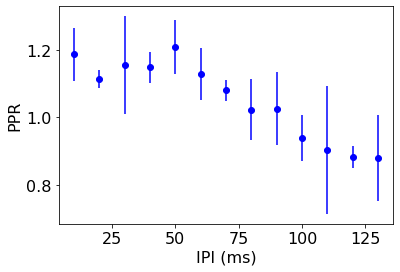

     PPR
IPI     
10     4
20     3
30     3
40     2
50     2
60     3
70     2
80     2
90     2
100    2
110    2
120    2
130    2
i= 1
110
p_val for IPI 10 : nan
p_val for IPI 20 : 0.8739723614704404
p_val for IPI 30 : nan
p_val for IPI 40 : nan
p_val for IPI 50 : 1.0
p_val for IPI 60 : 0.8380871136005005
p_val for IPI 70 : 1.0
p_val for IPI 80 : 1.0
p_val for IPI 90 : nan
p_val for IPI 100 : 0.0
p_val for IPI 120 : 1.0
p_val for IPI 130 : 1.0
[None, None, None, None, None, None, None, None, None, '***', None, None, None]


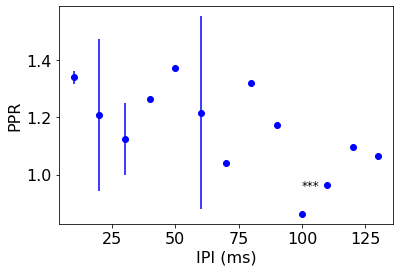

In [ ]:
# home barrel or neighboring barrel
plt.rcParams.update({'font.size': 16})

home_barrel_df = all_snr.query('`Home Barrel` == ROI')
neighbor_barrel_df = all_snr.query('`Home Barrel` != ROI')
titles = ['Home Barrel', 'Neighbor Barrel']

for pp_type, color in [['PPR', 'b']]: #, ['PPL', 'r'], ['PPHW', 'g']]:
    i = 0
    for barrel_df in [home_barrel_df, neighbor_barrel_df]:
        
        if pp_type in ['PPL', 'PPHW']:
            barrel_df = barrel_df[barrel_df['IPI'] > 20]
        group_by_ipi = barrel_df[['IPI', pp_type]].groupby(by=['IPI']).mean()
        group_by_ipi_std = barrel_df[['IPI', pp_type]].groupby(by=['IPI']).agg(np.std)
        group_by_ipi.reset_index(inplace=True)

        count_by_ipi = barrel_df[['IPI', pp_type]].groupby(by=['IPI']).count()
        print(count_by_ipi)

        # significance tests against the first IPI
        first_ipi = np.min(group_by_ipi['IPI'])
        pvals = []
        print("i=", i)
        if pp_type == 'PPR' and titles[i] == 'Neighbor Barrel':
            first_ipi = 110
        print(first_ipi)
        
        first_ipi_data = barrel_df[barrel_df['IPI'] == first_ipi][pp_type]
        for ipi in group_by_ipi['IPI']:
            if ipi == first_ipi:
                pvals.append(1)
                continue
            ipi_data = barrel_df[barrel_df['IPI'] == ipi][pp_type]
            
            # one-sided t-test if ipi_data is less than first_ipi_data
            t_stat, p_val = ttest_ind(ipi_data, first_ipi_data, alternative='less', equal_var=False)
            print("p_val for IPI", ipi, ":", p_val)
            pvals.append(p_val)

        def get_sig_level(x):
            if x < 0.001:
                return '***'
            if x < 0.01:
                return '**'
            if x < 0.05:
                return '*'
        significance_levels = [get_sig_level(x) for x in pvals]
        print(significance_levels)
            

        plt.scatter(group_by_ipi['IPI'], group_by_ipi[pp_type], c=color)
        plt.errorbar(group_by_ipi['IPI'], group_by_ipi[pp_type], 
                     group_by_ipi_std[pp_type], ls='none', c=color)
        y_label = pp_type
        if pp_type == 'PPL':
            y_label = "Paired-pulse ratio\n of Latency"
        if pp_type == 'PPHW':
            y_label = "Paired-pulse ratio\n of Half-width"
        # plt.title("Paired Pulse Depression in " + titles[i])
        
        # place significance levels on plot
        for j, txt in enumerate(significance_levels):
            plt.annotate(txt, (group_by_ipi['IPI'].iloc[j], min(0.95, group_by_ipi[pp_type].iloc[j] + 0.25)), fontsize=12)

        plt.xlabel("IPI (ms)")
        #plt.xticks([])
        plt.ylabel(y_label)
        plt.show()
        i += 1

In [ ]:
# home barrel or neighboring barrel
plt.rcParams.update({'font.size': 16})

home_barrel_df = all_snr.query('`Home Barrel` == ROI')
neighbor_barrel_df = all_snr.query('`Home Barrel` != ROI')
pvals = []
# significance tests: home versus neighbor
for ipi in group_by_ipi['IPI']:
    
    # one-sided t-test if ipi_data is less than first_ipi_data
    t_stat, p_val = ttest_ind(neighbor_barrel_df[neighbor_barrel_df['IPI'] == ipi]["PPR"],
                              home_barrel_df[home_barrel_df['IPI'] == ipi]["PPR"],  
                                alternative='less', 
                                equal_var=False)
    print("p_val for IPI", ipi, ":", p_val)
    pvals.append(p_val)

def get_sig_level(x):
    if x < 0.001:
        return '***'
    if x < 0.01:
        return '**'
    if x < 0.05:
        return '*'
significance_levels = [get_sig_level(x) for x in pvals]
print(significance_levels)

p_val for IPI 10 : nan
p_val for IPI 20 : nan
p_val for IPI 30 : nan
p_val for IPI 40 : nan
p_val for IPI 50 : nan
p_val for IPI 60 : 0.6479219227991312
p_val for IPI 70 : 0.0015894569336914143
p_val for IPI 80 : nan
p_val for IPI 90 : nan
p_val for IPI 100 : 0.001380578330487574
p_val for IPI 110 : 0.8176288487505023
p_val for IPI 120 : nan
p_val for IPI 130 : nan
[None, None, None, None, None, None, '**', None, None, '**', None, None, None]


64
68


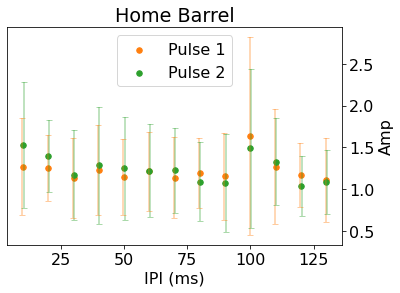

(13,) (13,) (13,) (13,)


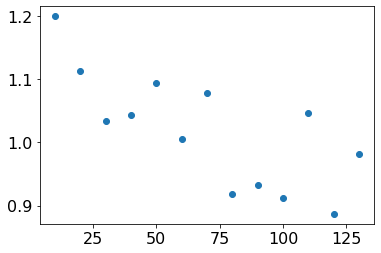

15
16


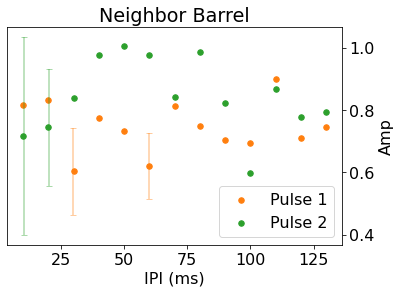

(13,) (13,) (13,) (13,)


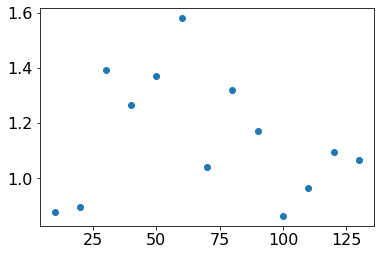

In [ ]:
# check for pulse 1 vs pulse 2 changes in latency or halfwidth
alpha = 0.5
should_group_by_ipi = True
if should_group_by_ipi:
    alpha = 1
ppr_snr = all_snr.query('PPR > 0')
ppr_snr = ppr_snr.query('PPR < 2')
pulse1_df = ppr_snr.query('Pulse == 1')
pulse2_df = ppr_snr.query('Pulse == 2')
titles = ['Pulse 1', 'Pulse 2']
pulse_colors = ['tab:orange', 'tab:green']

for barrel in ['Home Barrel', 'Neighbor Barrel']:
    for met_type, color in [['Amp', 'b']]: # , ['Latency', 'r'], ['Halfwidth', 'g']]:
        i = 0
        end1, end2 = None, None
        for pulse_df in [pulse1_df, pulse2_df]:
            total_n = len(pulse_df['IPI'])
            if barrel == 'Home Barrel':
                pulse_df = pulse_df.query('`Home Barrel` == ROI')
            else:
                pulse_df = pulse_df.query('`Home Barrel` != ROI')
            pulse_df = pulse_df[pulse_df['IPI'] > 5]
            subset_n = len(pulse_df['IPI'])
            print(len(pulse_df['IPI']))
            if should_group_by_ipi:
                pulse_df_std = pulse_df[['IPI', met_type]].groupby(by=['IPI']).agg(np.std)
                pulse_df = pulse_df[['IPI', met_type]].groupby(by=['IPI']).mean()
                pulse_df.reset_index(inplace=True)
                plt.errorbar(pulse_df['IPI'] + i * 0.5 - 0.25, pulse_df[met_type], 
                            pulse_df_std[met_type], ls='none', c=pulse_colors[i], capsize=3, alpha=0.4)
            if end1 is None:
                end1 = pulse_df
            else:
                end2 = pulse_df
            plt.scatter(pulse_df['IPI'], pulse_df[met_type], alpha=alpha,
                        s=30,
                        color=pulse_colors[i],
                         label=titles[i] )
            i += 1
        plt.title(barrel)
        plt.xlabel("IPI (ms)")
        plt.ylabel(met_type)
        #plt.ylim(0, 11)
        plt.legend()
        plt.gca().yaxis.set_label_position("right")
        plt.gca().yaxis.tick_right()
        
        plt.show()
        ppr = end2[met_type] / end1[met_type]
        print(ppr.shape, end1[met_type].shape, end2['IPI'].shape, end1['IPI'].shape)
        plt.scatter(end1['IPI'], ppr)
        plt.show()


     IPI       Amp
0     70  0.171305
1     10  0.300403
2     90  0.135772
3     60  0.186268
4    100  0.181730
..   ...       ...
187  120  0.013572
188   50  0.066096
189   40  0.064330
190  130  0.087439
191  100  0.022483

[192 rows x 2 columns]
     IPI       Amp
0     70  0.241990
1     10  0.397449
2     90  0.056524
3     60  0.293502
4    100  0.081262
..   ...       ...
187  120  0.015184
188   50  0.120708
189   40  0.098044
190  130  0.099530
191  100  0.034973

[192 rows x 2 columns]


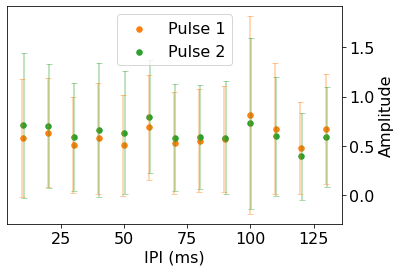

In [ ]:
# check for pulse 1 vs pulse 2 changes in latency or halfwidth
alpha = 0.2
titles = ['Pulse 1', 'Pulse 2']
pulse_colors = ['tab:orange', 'tab:green']
should_group_by_ipi = True
i = 0
if should_group_by_ipi:
    alpha = 1
for amp in [amps1, amps2]:

    if should_group_by_ipi:
        pulse_df = pd.DataFrame({'IPI': ipis, 'Amp': amp})
        pulse_df = pulse_df[pulse_df['IPI'] <150]
        print(pulse_df)
        pulse_df_std = pulse_df[['IPI', 'Amp']].groupby(by=['IPI']).agg(np.std)
        pulse_df = pulse_df[['IPI', 'Amp']].groupby(by=['IPI']).mean()
        pulse_df.reset_index(inplace=True)
        plt.errorbar(pulse_df['IPI'] + i * 0.5 - 0.25, pulse_df['Amp'], 
                    pulse_df_std['Amp'], ls='none', c=pulse_colors[i], 
                    capsize=3, alpha=0.4)

    plt.scatter(pulse_df['IPI'], pulse_df['Amp'], alpha=alpha,
                s=30,
                color=pulse_colors[i],
                    label=titles[i] )
    i += 1
plt.xlabel("IPI (ms)")
plt.ylabel('Amplitude')
plt.legend()
plt.gca().yaxis.set_label_position("right")
plt.gca().yaxis.tick_right()

plt.show()

In [ ]:
print(np.std(amps1), np.std(amps2))

0.5772726759660362 0.599275099327004


In [ ]:
# autoPhotoZ to save amplitude arrays for each measure window and 
# baseline correction to create PPR maps
def get_amp_array_filename(subdir, slic_loc_id, ipi, pulse):
    return subdir + "/" + "ampArray_" + slic_loc_id + "_ipi" + str(ipi) + "_p" + str(pulse) + ".dat"

overwrite_amp_arrays = False
select_amp_bkg = False
for subdir in data_map:
    aPhz = AutoPhotoZ(data_dir=subdir)
    if not select_amp_bkg and enable_photoZ_interact:
        aPhz.select_MaxAmp_array()
    print(subdir)
    for slic_id in data_map[subdir]:

        for loc_id in data_map[subdir][slic_id]:
            if type(loc_id) == str:
                continue
            slic_loc_id = str(slic_id) + "_" + str(loc_id)

            ipi_file = data_map[subdir][slic_id][loc_id]['shuffle_file']
            with open(ipi_file, 'r') as f:
                lines = f.readlines() 
            ipi_order = [x for x in lines]
            for k in range(len(ipi_order)):
                ipi = ipi_order[k].split("\t")
                ipi = int(ipi[1]) - int(ipi[0])
                ipi_order[k] = ipi

            # open zda files in order
            i_ipi = -1
            for zda_file in data_map[subdir][slic_id][loc_id]['zda_files']:

                i_ipi += 1
                try:
                    ipi = ipi_order[i_ipi]
                except Exception as e:
                    print(e)
                    print("Not enough IPIs for how many recordings we have! Last IPI:", ipi, "Check", subdir)
                print(slic_id, loc_id, "IPI:", ipi, "ms for recording", zda_file.split("/")[-1])
                
                # check if all amp arrays are already saved for this recording/IPI
                all_saved = True
                for i_pulse in [1, 2]:
                    amp_array_filename = get_amp_array_filename(subdir, slic_loc_id, ipi, i_pulse)
                    if not os.path.exists(amp_array_filename):
                        print("Missing", amp_array_filename)
                        all_saved = False
                        break
                if overwrite_amp_arrays:
                    all_saved = False

                if enable_photoZ_interact and not all_saved:
                    aPhz.open_zda_file(zda_file)

                    # set polynomial skip window to eclipse BOTH pulses
                    end_skip = 550
                    first_pulse_start = 356 - (ipi * 2)
                    skip_width = end_skip - first_pulse_start
                    aPhz.set_polynomial_skip_window(first_pulse_start,
                                                            skip_width=skip_width)
                for i_pulse in [1, 2]:
                    amp_array_filename = get_amp_array_filename(subdir, slic_loc_id, ipi, i_pulse)
                    if not os.path.exists(amp_array_filename) or overwrite_amp_arrays:
                        if enable_photoZ_interact and not all_saved:
                            #measure_window_start = 96 + (i_pulse - 1) * ipi * 2
                            measure_window_start = 356
                            if i_pulse == 1:
                                measure_window_start -= ipi * 2
                            aPhz.set_measure_window(measure_window_start, None)


                        # take Amplitude array from PhotoZ
                        if enable_photoZ_interact and not all_saved:
                            aPhz.save_background(filename=amp_array_filename)
                    else:
                        if not all_saved:
                            time.sleep(5)

                    if ipi not in data_map[subdir][slic_id][loc_id]:
                        data_map[subdir][slic_id][loc_id][ipi] = {}
                    if i_pulse not in data_map[subdir][slic_id][loc_id][ipi]:
                        data_map[subdir][slic_id][loc_id][ipi][i_pulse] = {}
                    data_map[subdir][slic_id][loc_id][ipi][i_pulse]['amp_array'] = amp_array_filename
                    
            if i_ipi < len(ipi_order) - 1:
                print("Not enough recordings for how many IPIs we have! Last IPI:", ipi, "Check", subdir)
                        

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/better_baseline/04-24-24
2 1 IPI: 70 ms for recording 02_01_01.zda
2 1 IPI: 10 ms for recording 02_01_02.zda
2 1 IPI: 20 ms for recording 02_01_03.zda
2 1 IPI: 90 ms for recording 02_01_04.zda
2 1 IPI: 60 ms for recording 02_01_05.zda
2 1 IPI: 40 ms for recording 02_01_06.zda
2 1 IPI: 100 ms for recording 02_01_07.zda
2 1 IPI: 130 ms for recording 02_01_08.zda
2 1 IPI: 110 ms for recording 02_01_09.zda
2 1 IPI: 50 ms for recording 02_01_10.zda
2 1 IPI: 30 ms for recording 02_01_11.zda
2 1 IPI: 80 ms for recording 02_01_12.zda
2 1 IPI: 120 ms for recording 02_01_13.zda
3 1 IPI: 120 ms for recording 03_01_02.zda
3 1 IPI: 130 ms for recording 03_01_03.zda
3 1 IPI: 80 ms for recording 03_01_04.zda
3 1 IPI: 40 ms for recording 03_01_05.zda
3 1 IPI: 90 ms for recording 03_01_06.zda
3 1 IPI: 70 ms for recording 03_01_07.zda
3 1 IPI: 30 ms for recording 03_01_08.zda
3 1 IPI: 60 ms for recording 03_01_09.zda
3 1 IPI: 50 ms for recording 03_

In [ ]:
# use amp arrays of both pulses to create PPR maps of different IPIs of the recordings 
def read_dat_arr_file(filename):
    data_arr = pd.read_csv(filename,
                                 sep='\t',
                                 header=None,
                                 names=['Index',  'Value'])
    data_arr = np.array(data_arr['Value']).reshape((80, 80))
    return data_arr

area_by_ipi = {'ipi': [], 'area': []}
ppr_hist = []
pphw_hist = []
ppl_hist = []
amp_cutoff = 1
# load in amp array files into dataframe for each IPI
for subdir in data_map:
    
    # extract date from subdir so we can look up metadata from master_df
    date = subdir.split("/")[-1].split('-')
    date = [int(x) for x in date]
    date[-1] += 2000
    date = "/".join([str(x) for x in date])
    metadata_date = master_df[master_df['Date'] == date]
    
    for slic_id in data_map[subdir]:
        for loc_id in data_map[subdir][slic_id]:
            if type(loc_id) == str:
                continue
            slic_loc_id = str(slic_id) + "_" + str(loc_id)
            metadata = metadata_date[metadata_date['Slice_Loc'] == slic_loc_id]
            medial_dir = metadata['Medial Dir'].item()
            stim_layer = metadata['Stim Layer'].item()
            caudal_rostral = metadata['Caudal/Rostral'].item()
            home_barrel = int(metadata['Home Barrel'].item())

            for ipi in data_map[subdir][slic_id][loc_id]:

                if type(ipi) == str:
                    continue
                
                # load amp files as numpy arrays using np.loadtxt
                amp_arr1 = get_amp_array_filename(subdir, slic_loc_id, ipi, 1)
                amp_arr2 = get_amp_array_filename(subdir, slic_loc_id, ipi, 2)
                amp_arr1 = read_dat_arr_file(amp_arr1)
                amp_arr2 = read_dat_arr_file(amp_arr2)
                ppr_map = amp_arr2 / amp_arr1

                area1 = np.sum(amp_arr1 > amp_cutoff)
                area2 = np.sum(amp_arr2 > amp_cutoff)
                if area1 > 0:
                    area_ratio = area2 / area1
                    area_by_ipi['area'].append(area_ratio)
                    area_by_ipi['ipi'].append(ipi)

                ppr_map[amp_arr1 < amp_cutoff] = 0
                '''if np.sum(ppr_map) > 0:
                    fig, axes = plt.subplots(1, 2)
                    axes[0].imshow(ppr_map, cmap='viridis')
                    axes[1].imshow(ppr_map > 1, cmap='viridis')
                    plt.show()
                    #print(np.max(ppr_map), np.min(ppr_map))'''

                # build histogram of PPR values for pixels above cutoff
                for i in range(amp_arr1.shape[0]):
                    for j in range(amp_arr1.shape[1]):
                        if amp_arr1[i, j] > amp_cutoff * 3 and 0 < ppr_map[i, j] < 2 and amp_arr2[i, j] != amp_arr1[i, j]:
                            ppr_hist.append(ppr_map[i, j])


<ipython-input-216-bd3863ed5157>:46: RuntimeWarning: divide by zero encountered in true_divide
  ppr_map = amp_arr2 / amp_arr1
<ipython-input-216-bd3863ed5157>:46: RuntimeWarning: invalid value encountered in true_divide
  ppr_map = amp_arr2 / amp_arr1


<ipython-input-234-1c0c101795ff>:46: RuntimeWarning: divide by zero encountered in true_divide
  ppr_map = amp_arr2 / amp_arr1
<ipython-input-234-1c0c101795ff>:46: RuntimeWarning: invalid value encountered in true_divide
  ppr_map = amp_arr2 / amp_arr1


           params       sigma
mu1      0.810105    4.321200
sigma1   0.124662    1.083099
A1       6.434943  246.493731
mu2      0.920718    0.156720
sigma2   0.103106    0.086940
A2      42.080217  328.991449


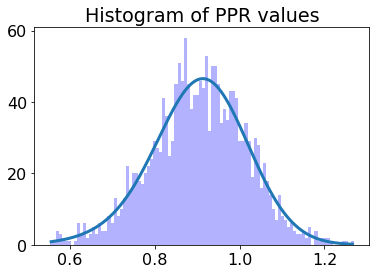

In [ ]:

# plot histogram of PPR values
y,x,_=plt.hist(ppr_hist, bins=100, color='b', alpha=0.3)
plt.title("Histogram of PPR values")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

#data generation
np.random.seed(123)
x=(x[1:]+x[:-1])/2 # for len(x)==len(y)

#x, y inputs can be lists or 1D numpy arrays

def gauss(x, mu, sigma, A):
    return A*np.exp(-(x-mu)**2/2/sigma**2)

def bimodal(x, mu1, sigma1, A1, mu2, sigma2, A2):
    return gauss(x,mu1,sigma1,A1)+gauss(x,mu2,sigma2,A2)

expected = (0.7, .02, 25, 0.8, .02, 15)
params, cov = curve_fit(bimodal, x, y, expected)
sigma=np.sqrt(np.diag(cov))
x_fit = np.linspace(x.min(), x.max(), 500)
#plot combined...
plt.plot(x_fit, bimodal(x_fit, *params), color='tab:blue', lw=3)
#...and individual Gauss curves
'''plt.plot(x_fit, gauss(x_fit, *params[:3]), 
         color='tab:orange', lw=3, ls="--", label='mean PPR: 0.74 ± 0.01' )
plt.plot(x_fit, gauss(x_fit, *params[3:]), 
         color='tab:green', lw=3, ls=":", label='mean PPR: 0.82 ± 0.07')'''
#and the original data points if no histogram has been created before
#plt.scatter(x, y, marker="X", color="black", label="original data")
#plt.legend(loc = 'upper left')
#plt.ylim(0, 17)
#plt.xlim(0.2, 1.2)
print(pd.DataFrame(data={'params': params, 'sigma': sigma}, index=bimodal.__code__.co_varnames[1:]))
plt.show() 